# Градиентный спуск

#### Gradient descent:
<br>

$f(x) \longrightarrow  \displaystyle \min_{x} $

$x^{t+1} = x^t-\alpha{f'(x^t)}$

$f(x^{t+1}) = f(x^t-\alpha{f'(x^t)})$

In [9]:
import torch

x = torch.tensor(
    [[1.,  2.,  3.,  4.],
     [5.,  6.,  7.,  8.],
     [9., 10., 11., 12.]]) 

#######
device = torch.device('cuda:0' 
                      if torch.cuda.is_available() 
                      else 'cpu')
x = x.to(device)
x.requires_grad_()# указываем, что мы хотим по этому тензору считать производную
#######

function = 10 * (x ** 2).sum()



function.backward() # вычисление производной методом обратного распространения ошибки

print(x.grad, '<- gradient')

tensor([[ 20.,  40.,  60.,  80.],
        [100., 120., 140., 160.],
        [180., 200., 220., 240.]], device='cuda:0') <- gradient


Порядок операции для вычисления производной

In [2]:
print(function.grad_fn)
print(function.grad_fn.next_functions[0][0])
print(function.grad_fn.next_functions[0][0].next_functions[0][0])
print(function.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0])

In [3]:
x = torch.tensor(
    [[1.,  2.,  3.,  4.],
     [5.,  6.,  7.,  8.],
     [9., 10., 11., 12.]], requires_grad=True)

In [17]:
function = 10 * (x ** 2).sum()
function.backward()

In [18]:
x, function

(tensor([[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.]], device='cuda:0', requires_grad=True),
 tensor(6500., device='cuda:0', grad_fn=<MulBackward0>))

In [19]:
x.grad

tensor([[ 40.,  80., 120., 160.],
        [200., 240., 280., 320.],
        [360., 400., 440., 480.]], device='cuda:0')

Записываем в data (тот же самый тензор, в котором requires_grad=False), для указания, что мы меняем не тензор, а только данные

In [20]:
x.data -= 0.001 * x.grad

В pytorch с каждым град. шагом градиенты накапливаются, чтобы сбросить нужно в ручную написать.

In [8]:
x.grad.zero_()

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

В pytorch функции с _ указывыают, что эта операция будет применена inplace.

## Функция градиентного спуска

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def show_contours(objective,
                  x_lims=[-10.0, 10.0], 
                  y_lims=[-10.0, 10.0],
                  x_ticks=100,
                  y_ticks=100):
    x_step = (x_lims[1] - x_lims[0]) / x_ticks
    y_step = (y_lims[1] - y_lims[0]) / y_ticks
    X, Y = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]
    res = []
    for x_index in range(X.shape[0]):
        res.append([])
        for y_index in range(X.shape[1]):
            x_val = X[x_index, y_index]
            y_val = Y[x_index, y_index]
            res[-1].append(objective(np.array([[x_val, y_val]]).T))
    res = np.array(res)
    plt.figure(figsize=(7,7))
    plt.contour(X, Y, res, 100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

In [22]:
import torch

x = torch.tensor(
    [8., 8.], requires_grad=True)
var_history = []
fn_history = []

def function_parabola(variable):
    return 10 * (variable ** 2).sum()

def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    variable.data -= 0.001 * variable.grad
    variable.grad.zero_()

for i in range(500):
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_parabola(x).data.cpu().numpy().copy())
    make_gradient_step(function_parabola, x)

Тоже самое только с другим оптимизатором

In [23]:
import torch

x = torch.tensor(
    [8., 8.], requires_grad=True)
var_history = []
fn_history = []

optimizer = torch.optim.SGD([x], lr=0.001)

def function_parabola(variable):
    return 10 * (variable ** 2).sum()

def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    optimizer.step()
    optimizer.zero_grad()
    
for i in range(500):
    var_history.append(x.data.numpy().copy())
    fn_history.append(function_parabola(x).data.cpu().numpy().copy())
    make_gradient_step(function_parabola, x)

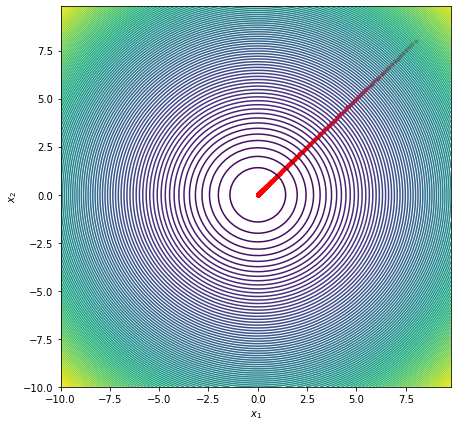

In [24]:
show_contours(function_parabola)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

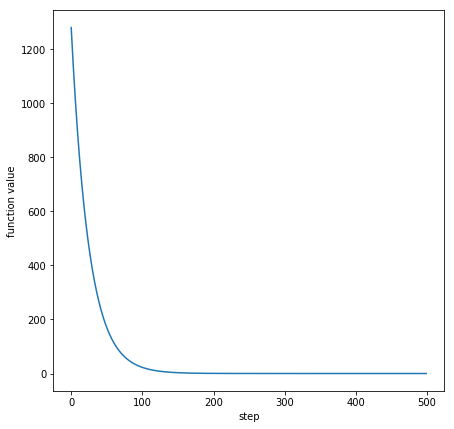

In [53]:
plt.figure(figsize=(7,7))
plt.plot(fn_history);
plt.xlabel('step')
plt.ylabel('function value');

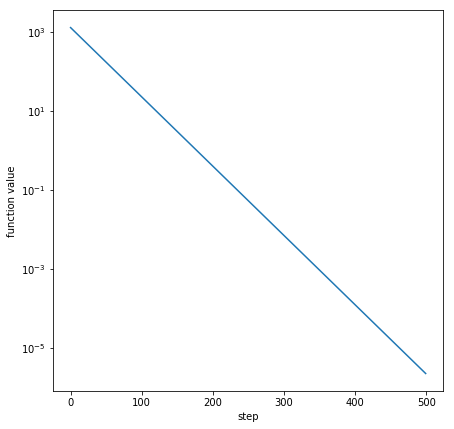

In [54]:
plt.figure(figsize=(7,7))
plt.semilogy(fn_history);
plt.xlabel('step')
plt.ylabel('function value');

### Более сложная функция

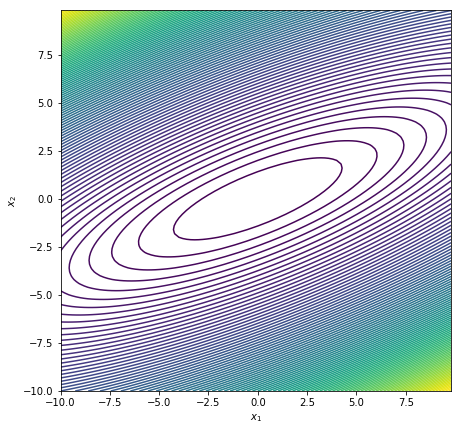

In [55]:
def function_skewed(variable):
    gramma = torch.tensor([[1., -1.], [1., 1.]]) @ torch.tensor([[1.0, 0.0], [0.0, 4.0]])
    res = 10 * (variable.unsqueeze(0) @ (gramma @ variable.unsqueeze(1))).sum()
    return res

def function_skewed_np(variable):
    gramma = np.array([[1, -1], [1, 1]]) @ np.array([[1.0, 0.0], [0.0, 4.0]])
    res = 10 * (variable.transpose(1, 0) @ (gramma @ variable)).sum()
    return res

show_contours(function_skewed_np)

In [56]:
x = torch.tensor(
    [8., 8.], requires_grad=True)
var_history = []
fn_history = []

optimizer = torch.optim.SGD([x], lr=0.001)

for i in range(500):
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_skewed(x).data.cpu().numpy().copy())
    make_gradient_step(function_skewed, x)

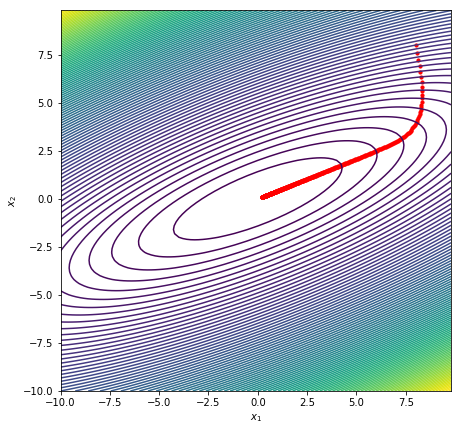

In [57]:
show_contours(function_skewed_np)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');